In [1]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 35.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.3 MB/s eta 0:00:0000:0100:01
  Attempting unins

In [ ]:
import re
import os
import requests
from typing import Dict, Optional
import numpy as np

try:
    from tqdm import tqdm  
    _has_tqdm = True
except ImportError:
    _has_tqdm = False


import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'
# или попробовать:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, f1_score, jaccard_score
import warnings
import os
import random
import inspect
from typing import List, Tuple, Optional, Union

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch import nn
from tqdm import tqdm

import monai
from monai.networks.nets import SwinUNETR
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from scipy import ndimage as ndi

<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
2025-10-16 15:08:37.865272: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760627318.032519      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760627318.079484      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import os
import re
import zipfile
import gdown
import numpy as np

def download_and_unpack_gdrive_gdown(url_or_id, dest_folder='.', out_filename=None,
                                     save_npy=False, quiet=False):
    """
    Скачивает файл с Google Drive через gdown и распаковывает
    """
    os.makedirs(dest_folder, exist_ok=True)

    # если передали только id — соберём URL
    if re.fullmatch(r"[A-Za-z0-9_-]{10,}", url_or_id):
        url = f"https://drive.google.com/uc?id={url_or_id}"
    else:
        url = url_or_id

    # имя выходного файла
    if out_filename is None:
        # попытка взять имя из URL, иначе дать дефолт
        if "id=" in url:
            out_filename = f"downloaded_{url.split('id=')[-1]}.bin"
        else:
            out_filename = os.path.basename(url) or "downloaded_file.bin"

    out_path = os.path.join(dest_folder, out_filename)

    # Скачиваем
    if not os.path.exists(out_path):
        gdown.download(url, out_path, quiet=quiet)

In [ ]:

file_id = "1NOUwAFtU_1KIlf8mQtB5xwSY-3NtYnDw"
url = f"https://drive.google.com/uc?id={file_id}"
download_and_unpack_gdrive_gdown(url_or_id=url,
                                           dest_folder="/kaggle/working",
                                           out_filename="seis_train.npz",
                                           quiet=False)

out_path = os.path.join("/kaggle/working", "seis_train.npz")


Downloading...
From (original): https://drive.google.com/uc?id=1ji5Vo4ZrAmJFALToEE6z6cQPhPMuzpTR
From (redirected): https://drive.google.com/uc?id=1ji5Vo4ZrAmJFALToEE6z6cQPhPMuzpTR&confirm=t&uuid=41e60ff0-df8c-435a-bbd5-8abbce7d3262
To: /kaggle/working/seis_train.npz
100%|██████████| 7.77G/7.77G [00:56<00:00, 138MB/s] 


In [ ]:

file_id = "1QHE1gn7B8Zt99Cw1KDwyfNv6wqhM5h49"
url = f"https://drive.google.com/uc?id={file_id}"
fault_val = download_and_unpack_gdrive_gdown(url_or_id=url,
                                           dest_folder="/kaggle/working",
                                           out_filename="fault_train.npz",
                                           quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1ZQuC4ndHs_YphJOJrWTfZGbShbhflzTs
From (redirected): https://drive.google.com/uc?id=1ZQuC4ndHs_YphJOJrWTfZGbShbhflzTs&confirm=t&uuid=2b1ebb99-1c6c-4f8f-a75b-44fe0c8deb97
To: /kaggle/working/fault_train.npz
100%|██████████| 8.01M/8.01M [00:00<00:00, 99.4MB/s]


In [ ]:

file_id = "1vVOkYAZkq08CtWosLd27Py4quvAaTjOa"
url = f"https://drive.google.com/uc?id={file_id}"
fault_val = download_and_unpack_gdrive_gdown(url_or_id=url,
                                           dest_folder="/kaggle/working",
                                           out_filename="seis_val.npz",
                                           quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1JadBTLzPPneg0gZlafJfpR0n8M5OJA7J
From (redirected): https://drive.google.com/uc?id=1JadBTLzPPneg0gZlafJfpR0n8M5OJA7J&confirm=t&uuid=4f5569db-3bcc-4b1c-b0fa-f8a12c8198b6
To: /kaggle/working/seis_val.npz
100%|██████████| 2.27G/2.27G [00:15<00:00, 148MB/s] 


In [ ]:

file_id = "1YIeB6J69RUozpKwWa84m8ZXgpaQMWmP7"
url = f"https://drive.google.com/uc?id={file_id}"
fault_val = download_and_unpack_gdrive_gdown(url_or_id=url,
                                           dest_folder="/kaggle/working",
                                           out_filename="fault_val.npz",
                                           quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1B86e1OwsaUg7GI4WQryXeVNFBFqETBPM
To: /kaggle/working/fault_val.npz
100%|██████████| 2.21M/2.21M [00:00<00:00, 169MB/s]


In [8]:

file_id = "1bKLjIzaGMm8zWyYZhOob6-xKL2_qV5YT"
url = f"https://drive.google.com/uc?id={file_id}"
fault_val = download_and_unpack_gdrive_gdown(url_or_id=url,
                                           dest_folder="/kaggle/working",
                                           out_filename="checkpoint.pth",
                                           quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1bKLjIzaGMm8zWyYZhOob6-xKL2_qV5YT
From (redirected): https://drive.google.com/uc?id=1bKLjIzaGMm8zWyYZhOob6-xKL2_qV5YT&confirm=t&uuid=677ee9db-b134-4fa5-ac45-64e9388ff70a
To: /kaggle/working/checkpoint.pth
100%|██████████| 731M/731M [00:09<00:00, 80.3MB/s] 


In [ ]:
from typing import Union, Sequence, Tuple, Optional, Dict, Iterable
import numpy as np
import os
import random

class SeisFaultDataset:
    """
    Датасет для пар (сейсмика, fault) в виде 3D numpy-массивов.

    Поддерживаемые источники:
    - путь к .npz файлу (будет открыт через np.load(..., mmap_mode='r'))
    - dict-like mapping имя -> np.ndarray

    Парирование:
    - если pairs не переданы, автоматически берётся отсортированное пересечение ключей
      между seismic и fault источниками. Если пересечение пусто — бросается исключение.

    Основные опции:
    - target_shape: размер кропа (z,y,x)
    - random_crop: True — случайные кропы, False — кропы с нулевого/центрального начала
    - seed: для детерминированности
    - normalize_seis: применять z-score нормализацию к сейсмике
    """

    def __init__(
        self,
        seis_source: Union[str, Dict[str, np.ndarray]],
        fault_source: Union[str, Dict[str, np.ndarray]],
        pairs: Optional[Sequence[Tuple[str, str]]] = None,
        target_shape: Tuple[int, int, int] = (128, 128, 128),
        random_crop: bool = True,
        seed: Optional[int] = None,
        normalize_seis: bool = True,
    ):
        # параметры
        self.target_shape = tuple(int(x) for x in target_shape)
        if len(self.target_shape) != 3:
            raise ValueError("target_shape должен быть кортежем длины 3")
        self.random_crop = bool(random_crop)
        self.normalize_seis = bool(normalize_seis)
        self._rng = random.Random(seed)

        # загрузка источников (path -> npz mmap или оставляем dict)
        self._seis_npz = None
        self._fault_npz = None

        if isinstance(seis_source, str):
            if not os.path.exists(seis_source):
                raise FileNotFoundError(seis_source)
            self._seis_npz = np.load(seis_source, mmap_mode='r')
            seis_source = self._seis_npz

        if isinstance(fault_source, str):
            if not os.path.exists(fault_source):
                raise FileNotFoundError(fault_source)
            self._fault_npz = np.load(fault_source, mmap_mode='r')
            fault_source = self._fault_npz

        # ожидаем mapping name->ndarray
        self.seis_source = seis_source
        self.fault_source = fault_source

        # парами: либо явно, либо пересечение ключей
        if pairs is not None:
            self.pairs = list(pairs)
        else:
            seis_keys = self._keys_from_source(self.seis_source)
            fault_keys = self._keys_from_source(self.fault_source)
            common = sorted(set(seis_keys).intersection(fault_keys))
            if not common:
                raise ValueError("Нет общих ключей между seismic и fault источниками")
            # пары (имя, имя)
            self.pairs = [(k, k) for k in common]

        if len(self.pairs) == 0:
            raise ValueError("No pairs available")

    # ---- Вспомогательные методы ----

    def _keys_from_source(self, src):
        """Возвращает список ключей для mapping-источника или .files для npz."""
        if hasattr(src, 'files'):
            return list(src.files)
        if isinstance(src, dict):
            return list(src.keys())
        # obj, у которого можно взять ключи через итерацию
        try:
            return list(src.keys())
        except Exception:
            raise ValueError(f"Unsupported source type: {type(src)}")

    def _get_array(self, src, key):
        """Простая загрузка массива; ожидаем numpy.ndarray 3D."""
        arr = src[key]
        if not isinstance(arr, np.ndarray):
            # попытка конвертации (обычно не нужна)
            arr = np.asarray(arr)
        if arr.ndim != 3:
            raise ValueError(f"Ключ {key}: ожидается 3D массив, получено {arr.ndim}D")
        return arr

    def _compute_crop_start(self, shape: Tuple[int, int, int]) -> Tuple[int, int, int]:
        """Вычислить стартовые индексы для кропа (случайно или ноль/центр)."""
        starts = []
        for i in range(3):
            max_start = shape[i] - self.target_shape[i]
            if max_start <= 0:
                starts.append(0)
            else:
                if self.random_crop:
                    starts.append(self._rng.randint(0, max_start))
                else:
                    # по умолчанию — центрированный кроп если есть запас
                    starts.append(max_start // 2)
        return tuple(starts)

    def _zscore_normalize(self, vol: np.ndarray) -> np.ndarray:
        """Z-score нормализация (для сейсмики)."""
        v = vol.astype(np.float32, copy=False)
        mu = v.mean()
        sigma = v.std()
        eps = 1e-8
        return (v - mu) / (sigma + eps)

    # ---- интерфейс Dataset ----

    def __len__(self) -> int:
        return len(self.pairs)

    def __getitem__(self, idx: int):
        """Вернёт (seis_crop, fault_crop, meta)."""
        if idx < 0:
            idx = len(self) + idx
        seis_key, fault_key = self.pairs[idx]

        seis = self._get_array(self.seis_source, seis_key)
        fault = self._get_array(self.fault_source, fault_key)

        # берем кроп по форме seismic-а
        starts = self._compute_crop_start(seis.shape)
        slices = tuple(slice(st, st + ts) for st, ts in zip(starts, self.target_shape))

        seis_crop = seis[slices]
        fault_crop = fault[slices]

        if self.normalize_seis:
            seis_crop = self._zscore_normalize(seis_crop)

        meta = {
            "seis_key": seis_key,
            "fault_key": fault_key,
            "crop_start": starts,
            "original_shapes": (seis.shape, fault.shape),
        }
        return seis_crop, fault_crop, meta

    def close(self):
        """Закрыть mmap .npz если он был открыт."""
        if self._seis_npz is not None:
            try:
                self._seis_npz.close()
            except Exception:
                pass
            self._seis_npz = None
        if self._fault_npz is not None:
            try:
                self._fault_npz.close()
            except Exception:
                pass
            self._fault_npz = None

    def __del__(self):
        self.close()


In [7]:
train_ds = SeisFaultDataset("/kaggle/working/seis_train.npz", "/kaggle/working/fault_train.npz", 
                      target_shape=(128,128,128), seed=42)

val_ds = SeisFaultDataset("/kaggle/working/seis_val.npz", "/kaggle/working/fault_val.npz", 
                      target_shape=(128,128,128), seed=42)



In [ ]:
def save_checkpoint(path, model, optimizer=None, epoch=None, extra=None):
    """
    Корректно сохраняет state_dict модели (без 'module.'), optimizer и мета.
    """
    model_to_save = model.module if isinstance(model, nn.DataParallel) else model
    ckpt = {"epoch": epoch, "model_state_dict": model_to_save.state_dict()}
    if optimizer is not None:
        ckpt["optimizer_state_dict"] = optimizer.state_dict()
    if extra:
        ckpt.update(extra)
    torch.save(ckpt, path)


def _strip_module_prefix(state_dict):
    # удаляем все префиксы "module." (на случай многократных вхождений)
    new_state = {}
    for k, v in state_dict.items():
        if k.startswith("module."):
            new_state[k[len("module."):]] = v
        else:
            new_state[k] = v
    return new_state


def _move_optimizer_state_to_device(opt_state, device):
    # переносим все тензоры в optimizer.state на нужное устройство
    for state in opt_state.values():
        for k, v in list(state.items()):
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)


def load_checkpoint(
    path,
    model,
    optimizer=None,
    device=torch.device("cpu"),
    strict=False,
    verbose=True,
):
    """
    Загрузка чекпойнта с учётом DataParallel
    """
    # безопасно загружаем на cpu, а потом переносим model/opt на device
    ckpt = torch.load(path, map_location="cpu")
    if verbose:
        print(f"[ckpt] loaded checkpoint type={type(ckpt)}")

    # извлекаем state_dict модели
    if isinstance(ckpt, dict):
        state = ckpt.get("model_state_dict", ckpt.get("state_dict", None))
        if state is None:
            # возможно, чекпойнт — это просто state_dict
            # проверим: если все значения — тензоры, считаем это state_dict
            if all(isinstance(v, torch.Tensor) for v in ckpt.values()):
                state = ckpt
            else:
                raise RuntimeError("Checkpoint dict doesn't contain recognizable model state.")
    else:
        raise RuntimeError("Checkpoint seems to contain a pickled model object. "
                           "Prefer saving state_dict instead of full model object.")

    # убираем 'module.' если нужно
    state = _strip_module_prefix(state)

    # проверяем размеры ключей и предупреждаем о несоответствиях до загрузки
    model_to_load = model.module if isinstance(model, nn.DataParallel) else model
    model_state = model_to_load.state_dict()
    mismatched_shapes = []
    for k, v in state.items():
        if k in model_state and v.shape != model_state[k].shape:
            mismatched_shapes.append((k, v.shape, model_state[k].shape))
    if mismatched_shapes and verbose:
        print("[ckpt] WARNING: found tensors with mismatched shapes (ckpt vs model):")
        for k, s_ckpt, s_model in mismatched_shapes[:10]:
            print(f"   {k}: ckpt{tuple(s_ckpt)} != model{tuple(s_model)}")
        if len(mismatched_shapes) > 10:
            print(f"   ... and {len(mismatched_shapes)-10} more")

    # загружаем state_dict (strict может быть False, чтобы не падать)
    load_res = model_to_load.load_state_dict(state, strict=strict)
    if verbose:
        # load_state_dict возвращает NamedTuple(missing_keys, unexpected_keys)
        print("[ckpt] load_state_dict result:", load_res)

    # переносим модель на device
    model.to(device)

    # если есть optimizer и он сохранялся — грузим и переносим тензоры оптимизатора
    if optimizer is not None and isinstance(ckpt, dict) and "optimizer_state_dict" in ckpt:
        optimizer.load_state_dict(ckpt["optimizer_state_dict"])
        _move_optimizer_state_to_device(optimizer.state, device)
        if verbose:
            print("[ckpt] optimizer state loaded and moved to", device)

    return ckpt


In [ ]:
import inspect
from typing import List, Optional, Tuple, Dict, Any
import torch
import torch.nn as nn


def build_swinunetr_from_params(params: Dict[str, Any], in_ch: int = 1, out_ch: int = 1, device: torch.device = None) -> nn.Module:
    """
    Построить SwinUNETR из словаря params, отфильтровав те параметры конструктора,
    которые разрешены сигнатурой класса.

    Возвращает модель на указанном device. Если доступно несколько GPU — оборачивает в DataParallel.
    """
    device = DEVICE if device is None else device
    sig = inspect.signature(SwinUNETR.__init__)
    allowed = {p for p in sig.parameters.keys() if p not in ("self", "in_channels", "out_channels")}
    call_kwargs = {k: v for k, v in params.items() if k in allowed}
    model = SwinUNETR(in_ch, out_ch, **call_kwargs)
    if torch.cuda.device_count() > 1:
        print(f"[build] Wrapping model with DataParallel on {torch.cuda.device_count()} GPUs")
        model = nn.DataParallel(model)
    return model.to(device)


def diag_forward_shapes(model: nn.Module, imgs: torch.Tensor, module_name_filters: Optional[List[str]] = None, device: torch.device = None) -> List[Tuple[str, Tuple[int, ...]]]:
    """
    Запускает быстрый forward (без вычисления градиентов) и собирает формы outputs
    от модулей, имена которых содержат любую подстроку из module_name_filters.

    Возвращает список (ClassName, shape).
    Работает корректно как для обычной модели, так и для DataParallel обёртки.
    """
    device = DEVICE if device is None else device
    shapes = []
    handles = []

    # если DataParallel — брать оригинальную модель для перебора модулей
    actual = model.module if isinstance(model, nn.DataParallel) else model

    def hook(module, inp, out):
        # пытаемся взять shape у out
        try:
            shp = tuple(out.shape)
            shapes.append((module.__class__.__name__, shp))
        except Exception:
            pass

    # Регистрируем хуки на отфильтрованные модули
    for name, mod in actual.named_modules():
        if module_name_filters is None or any(f in name for f in module_name_filters):
            try:
                handles.append(mod.register_forward_hook(hook))
            except Exception:
                # некритично — пропустим модуль
                pass

    try:
        model.eval()
        with torch.no_grad():
            _ = model(imgs.to(device))
    except Exception as e:
        # Если forward упал — всё равно вернём что успели собрать
        # Для отладки можно пробросить исключение, но для авто- tune это полезно сохранять.
        print("[diag_forward_shapes] forward failed:", e)
    finally:
        for h in handles:
            try:
                h.remove()
            except Exception:
                pass

    return shapes


def has_1x1x1_activation(shapes: List[Tuple[str, Tuple[int, ...]]]) -> bool:
    """
    Проверяет, есть ли среди собранных форм тензоры, у которых последние три размеры == (1,1,1).
    Возвращает True если найдена такая активация.
    """
    for clsname, shp in shapes:
        if len(shp) >= 3 and shp[-3:] == (1, 1, 1):
            return True
    return False


def auto_adjust_and_build_model(sample_imgs: torch.Tensor,
                                base_params: Dict[str, Any],
                                max_attempts: int = 6,
                                device: torch.device = None) -> Tuple[nn.Module, Dict[str, Any]]:
    """
    Авто-подстройка параметров модели:
    - Пытается создать модель с base_params.
    - Делает быстрый forward diag; если где-то появляются активации с spatial (1,1,1) —
      последовательно уменьшает глубины (depths) начиная с самого глубокого уровня.
    - Если depths уже минимальны (все ==1), пробует уменьшить feature_size пополам до минимума 16.
    - Повторяет до max_attempts раз и возвращает (model, used_params) при успехе.

    Бросает RuntimeError при неудаче.
    """
    device = DEVICE if device is None else device
    params = dict(base_params)  # локальная копия
    attempt = 0
    last_err = None

    while attempt < max_attempts:
        attempt += 1
        print(f"[auto-tune] Attempt {attempt}: depths={params.get('depths')} feature_size={params.get('feature_size')}")
        # Попытка создать модель
        try:
            model = build_swinunetr_from_params(params, device=device)
        except Exception as e:
            last_err = e
            print("[auto-tune] Model instantiation failed:", e)
            # Если проблема в памяти — пробуем уменьшить feature_size
            fs = params.get("feature_size")
            if isinstance(fs, int) and fs > 16:
                params["feature_size"] = max(16, fs // 2)
                print("[auto-tune] Reducing feature_size ->", params["feature_size"])
                torch.cuda.empty_cache()
                continue
            raise

        # Быстрая диагностика форм
        shapes = diag_forward_shapes(model, sample_imgs, module_name_filters=["encoder", "decoder"], device=device)
        if not has_1x1x1_activation(shapes):
            print("[auto-tune] Success — no 1x1x1 activations detected.")
            return model, params

        # Найдена 1x1x1 активация — уменьшаем depths, начиная с конца
        print("[auto-tune] Detected 1x1x1 activation — will try to reduce depths/feature_size.")
        depths = list(params.get("depths", (2, 2, 2, 2)))
        reduced = False
        for i in range(len(depths) - 1, -1, -1):
            if depths[i] > 1:
                depths[i] = 1
                reduced = True
                break

        if reduced:
            params["depths"] = tuple(depths)
            print("[auto-tune] Reduced depths ->", params["depths"])
            try:
                del model
            except Exception:
                pass
            torch.cuda.empty_cache()
            continue

        # depths уже минимальны — пробуем уменьшить feature_size
        fs = params.get("feature_size", 48)
        if isinstance(fs, int) and fs > 16:
            params["feature_size"] = max(16, fs // 2)
            print("[auto-tune] Depths minimal — reducing feature_size ->", params["feature_size"])
            try:
                del model
            except Exception:
                pass
            torch.cuda.empty_cache()
            continue

        # Нечего уже уменьшать
        try:
            del model
        except Exception:
            pass
        torch.cuda.empty_cache()
        raise RuntimeError("Auto-tune failed: cannot remove 1x1x1 activations")

    # Если цикл закончился без успеха
    raise RuntimeError(f"Auto-tune failed after {max_attempts} attempts. Last error: {last_err}")


[auto-tune] Attempt 1, depths=(2, 2, 2, 1)
Using 2 GPUs!
[auto-tune] OK — no 1x1x1 activations detected.
Using MODEL_PARAMS (after auto-adjust): {'patch_size': (2, 2, 2), 'depths': (2, 2, 2, 1), 'num_heads': (3, 6, 12, 24), 'window_size': (7, 7, 7), 'qkv_bias': True, 'mlp_ratio': 4.0, 'feature_size': 48, 'drop_rate': 0.0, 'attn_drop_rate': 0.0, 'dropout_path_rate': 0.1, 'patch_norm': True, 'spatial_dims': 3}
[ckpt] loaded checkpoint type=<class 'dict'>
[ckpt] load_state_dict result: <All keys matched successfully>
[ckpt] optimizer state loaded and moved to cuda
Model param count: 60359563
keys in ckpt but not in model: []
keys in model but not in ckpt: []


Val: 100%|██████████| 288/288 [05:30<00:00,  1.15s/it]


Epoch 1 | Train loss: 1.0538 | Val loss: 1.1489 | F1: 0.43850069631850125
Best model updated: 0.43850069631850125


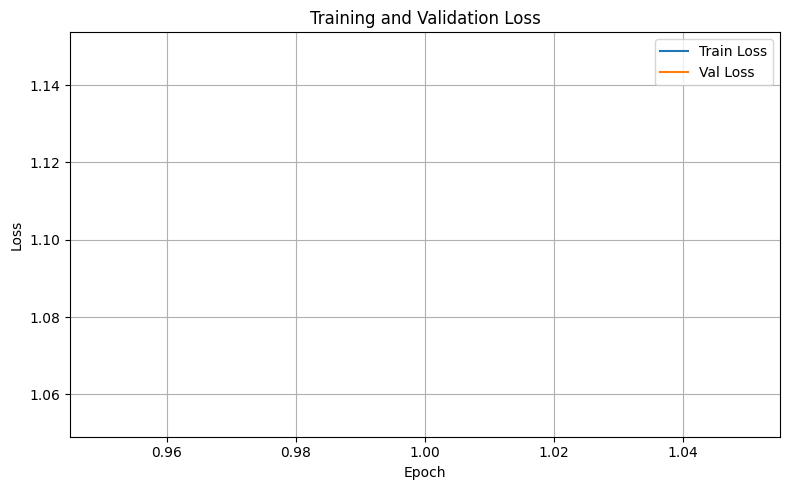

Training finished. Best val Dice: 0.43850069631850125


In [ ]:

class CombinedLoss(nn.Module):
    def __init__(self, weight_bce=1.0, weight_dice=1.0):
        super().__init__()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.bce = nn.BCEWithLogitsLoss(
            pos_weight=torch.tensor([13.3], device=device)
        )
        self.dice = monai.losses.DiceLoss(sigmoid=True, squared_pred=False, reduction="mean")
        self.w_bce = weight_bce
        self.w_dice = weight_dice
    
    def forward(self, logits, target):
        if target.dim() == logits.dim() - 1:
            target = target.unsqueeze(1)
        return self.w_bce * self.bce(logits, target) + self.w_dice * self.dice(logits, target)

def train_epoch(model, dataloader, optimizer, loss_fn, epoch):
    model.train()
    running_loss = 0.0
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Train E{epoch}")
    
    for i, batch in pbar:
        if len(batch) == 3:
            imgs, masks, metas = batch
        else:
            imgs, masks = batch
        
        imgs = imgs.unsqueeze(1).float()
        masks = masks.unsqueeze(1).float()
        
        imgs = imgs.to(DEVICE, non_blocking=True)
        masks = masks.to(DEVICE, non_blocking=True)
        
        optimizer.zero_grad()
        try:
            outputs = model(imgs)
        except ValueError as e:
            msg = str(e)
            if "Expected more than 1 spatial element" in msg:
                raise RuntimeError("Runtime forward error: spatial dims too small. Consider increasing ROI or manual model changes.\n" + msg)
            else:
                raise
        
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += float(loss.item())
        pbar.set_postfix(loss=running_loss / (i + 1))
    
    return running_loss / len(dataloader)

def validate(model, dataloader):
    model.eval()
    loss_fn = CombinedLoss()
    val_loss = 0.0

    TP = 0
    FP = 0
    FN = 0
    total_pixels = 0

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc="Val")
    with torch.no_grad():
        for i, batch in pbar:
            if len(batch) == 3:
                imgs, masks, metas = batch
            else:
                imgs, masks = batch

            imgs = imgs.unsqueeze(1).float().to(DEVICE)
            masks = masks.unsqueeze(1).float().to(DEVICE)

            logits = sliding_window_inference(
                inputs=imgs,
                roi_size=ROI_SIZE,
                sw_batch_size=SW_BATCH_SIZE,
                predictor=model,
                overlap=OVERLAP,
            )

            # loss
            val_loss += float(loss_fn(logits, masks).item())

            # preds
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()

            # приводим к 1D
            preds_flat = preds.view(-1)
            masks_flat = masks.view(-1)

            # аккуратно считаем TP/FP/FN на GPU, затем переводим в int
            TP += int(((preds_flat == 1.0) & (masks_flat == 1.0)).sum().item())
            FP += int(((preds_flat == 1.0) & (masks_flat == 0.0)).sum().item())
            FN += int(((preds_flat == 0.0) & (masks_flat == 1.0)).sum().item())

            total_pixels += preds_flat.numel()

    # усреднённый лосс по батчам
    val_loss = val_loss / max(1, len(dataloader))

    # F1 (без деления на ноль)
    denom = 2 * TP + FP + FN
    if denom == 0:
        # нет позитивных пикселей ни в GT, ни в предсказаниях -> F1 не определён
        val_f1 = float("nan")
    else:
        val_f1 = 2.0 * TP / denom

    return val_loss, val_f1


ROI_SIZE = (128, 128, 128) 
LEARNING_RATE = 1e-4
ROOT_DIR = "./checkpoints"
SW_BATCH_SIZE = 2
OVERLAP = 0.25

MODEL_PARAMS = dict(
    patch_size=(2, 2, 2),
    depths=(2, 2, 2, 1),      
    num_heads=(3, 6, 12, 24),
    window_size=(7, 7, 7),
    qkv_bias=True,
    mlp_ratio=4.0,
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.1,
    patch_norm=True,
    spatial_dims=3,
)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 2

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


# детерминированный рандом-генератор для reproducibility
generator = torch.Generator()
generator.manual_seed(SEED)

#train_ds, val_ds, out = torch.utils.data.random_split(ds, [train_len, val_len, out_len], generator=generator)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

try:
    batch = next(iter(train_loader))
except StopIteration:
    raise RuntimeError("train_loader yielded no data for autotune")
imgs_sample = batch[0].unsqueeze(1).float() if isinstance(batch, (list, tuple)) else batch.unsqueeze(1).float()

# auto-adjust and build model
model, used_params = auto_adjust_and_build_model(imgs_sample, max_attempts=6)
print("Using MODEL_PARAMS (after auto-adjust):", used_params)

ckpt_path = "/kaggle/working/checkpoint.pth"
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

ckpt = load_checkpoint(ckpt_path, model, optimizer=optimizer, device=DEVICE, strict=False, verbose=True)
# после загрузки
model_to_inspect = model.module if isinstance(model, nn.DataParallel) else model
print("Model param count:", sum(p.numel() for p in model_to_inspect.parameters()))
# сравнить ключи чекпойнта и модели
ckpt_state = ckpt.get("model_state_dict", ckpt.get("state_dict", ckpt))
ckpt_keys = set(k.replace("module.", "") for k in ckpt_state.keys())
model_keys = set(model_to_inspect.state_dict().keys())
print("keys in ckpt but not in model:", sorted(list(ckpt_keys - model_keys))[:20])
print("keys in model but not in ckpt:", sorted(list(model_keys - ckpt_keys))[:20])


loss_fn = CombinedLoss()
best_val_dice = -1.0

train_losses = []
val_losses = []
val_dices = []
val_f1s = []
val_aps = []
val_ious = []

best_val_dice = -1.0
best_val_f1 = 0

os.makedirs(ROOT_DIR, exist_ok=True)
loss_plot_path = os.path.join(ROOT_DIR, "training_loss.png")

for epoch in range(1, 2):
    train_loss = train_epoch(model, train_loader, optimizer, loss_fn, epoch)

    val_loss, val_f1 = validate(model, val_loader)

    print(
        f"Epoch {epoch} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f} | "
        f"F1: {val_f1 if not np.isnan(val_f1) else 'nan'}"
    )

    model_to_save = model.module if isinstance(model, nn.DataParallel) else model
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model_to_save.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "val_f1": val_f1,
        "val_loss": val_loss,
    }
    torch.save(checkpoint, os.path.join(ROOT_DIR, f"checkpoint_epoch_{epoch}.pth"))

    # обновим лучший по F1
    if (not np.isnan(val_f1) and val_f1 > best_val_f1):  
        best_val_f1 = val_f1
        torch.save(checkpoint, os.path.join(ROOT_DIR, "best_checkpoint.pth"))
        print("Best model updated:", best_val_f1)
         # обновляем исторические списки
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_f1s.append(val_f1)

    # рисуем и сохраняем график loss (train + val)
    try:
        plt.figure(figsize=(8, 5))
        epochs_range = list(range(1, len(train_losses) + 1))
        plt.plot(epochs_range, train_losses, label="Train Loss")
        plt.plot(epochs_range, val_losses, label="Val Loss")
        plt.title("Training and Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        # сохраняем в верхнюю директорию (ROOT_DIR)
        plt.savefig(loss_plot_path)
        plt.show()  # в ноутбуке Kaggle покажет график
        plt.close()
    except Exception as e:
        warnings.warn(f"Failed to plot/save loss figure: {e}")

print("Training finished. Best val f1:", best_val_f1)

----